<a href="https://colab.research.google.com/github/zenAurelius/rai-h-/blob/master/TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# [x] https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# [.] time series
# [.] recomendation : un co avec son historique => recomend
# [.] custom loss function : https://www.google.com/search?client=firefox-b-d&q=custom+loss+function+betting / 
# [.] Critère de Kelly : https://fr.wikipedia.org/wiki/Crit%C3%A8re_de_Kelly
# [.] https://trueskill.org/
# [.] Plusieurs dataset en entrée : https://stackoverflow.com/questions/63979750/input-multiple-datasets-to-tensorflow-model
# [.] CNN non image : https://towardsdatascience.com/convolutional-neural-network-on-a-structured-bank-customer-data-358e6b8aa759
# [.] https://keras.io/examples/keras_recipes/bayesian_neural_networks/
# [.] https://en.wikipedia.org/wiki/Types_of_artificial_neural_networks
# [.] https://github.com/iridiumblue/roc-star
# [.] RL : https://towardsdatascience.com/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02

In [1]:
# SI ON EST SUR COLAB
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
def topath(filename):
    return f"/content/drive/My Drive/HRAI/datas/{filename}"

tf.__version__

Mounted at /content/drive


'2.8.2'

In [2]:
!cp /content/drive/MyDrive/Colab\ Notebooks/utils.py /content
import importlib
import utils as utl

In [ ]:
importlib.reload(utils)

In [3]:
# PLOTTERS
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# PLOT METRICS
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    if 'val_'+metric in history.history :
      plt.plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

# PLOT CONFUSION MATRIX
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('PAS PLACE OK (True Negatives): ', cm[0][0])
  print('PLACE KO (False Positives): ', cm[0][1])
  print('PAS PLACE KO (False Negatives): ', cm[1][0])
  print('PLACE OK (True Positives): ', cm[1][1])

In [4]:
# PRE PROCESSING LAYERS

# NORMALIZATION
def get_normalization_layer(name, ds = None, df = None):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  if ds is not None:
    normalizer.adapt(ds.map(lambda x, y: x[name]))
  elif df is not None:
    normalizer.adapt(df[name])

  return normalizer


# CATEGORY ENCODING
def get_category_encoding_layer(name, dtype, dataset=None, dataframe=None, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  if dataset is not None:
    features = dataset.map(lambda x, y: x[name])
  elif dataframe is not None:
    features = dataframe[name]

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(features)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

# CREATE INPUT LAYERS
def create_input_layers(dataset=None, dataframe=None, cat_int_token=5, cat_str_token=5):
  all_inputs = []
  encoded_features = []
  features_dict = {}

  # Integer Index features.
  for header in cat_int_cols:
    cat_int_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    if dataset is not None:
      encoding_layer = get_category_encoding_layer(name=header, dataset=dataset, dtype='int64', max_tokens=cat_int_token)
    elif dataframe is not None:
      encoding_layer = get_category_encoding_layer(name=header, dataframe=dataframe, dtype='int64', max_tokens=cat_int_token)
      features_dict[header] = tf.convert_to_tensor(dataframe[header])
    encoded_col = encoding_layer(cat_int_col)
    all_inputs.append(cat_int_col)
    encoded_features.append(encoded_col)

  # Numerical features.
  for header in numerical_cols:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    if dataset is not None:
      normalization_layer = get_normalization_layer(header, ds=dataset)
    elif dataframe is not None:
      normalization_layer = get_normalization_layer(header, df=dataframe)
      features_dict[header] = tf.convert_to_tensor(dataframe[header])
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

  # String Index features.
  for header in cat_str_cols:
    cat_str_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    if dataset is not None:
      encoding_layer = get_category_encoding_layer(name=header, dataset=dataset, dtype='string', max_tokens=cat_str_token)
    elif dataframe is not None:
      encoding_layer = get_category_encoding_layer(name=header, dataframe=dataframe, dtype='string', max_tokens=cat_str_token)
      features_dict[header] = tf.convert_to_tensor(dataframe[header])
    encoded_col = encoding_layer(cat_str_col)
    all_inputs.append(cat_str_col)
    encoded_features.append(encoded_col)

  return all_inputs, encoded_features, features_dict

# TO TENSORS
def to_tensors(data):
  df = data.copy()
  labels = df['TARGET'].astype('float32')
  df = data.drop(columns=['TARGET'])
  df_x = util.extract_x(df, features_cols) 
  return df_x,labels

# DF TO DATASET
def df_to_dataset(df_in, features_cols, shuffle=True, batch_size=32, targets_name=['TARGET']):
  df = df_in.copy()
  labels = df[targets_name]
  df = df.drop(columns=targets_name)
  df_x = utl.extract_x(df, features_cols)
  ds = tf.data.Dataset.from_tensor_slices((dict(df_x), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df_in))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds  
  
# TO DS
def to_ds(data, features_cols, targets_name=['TARGET'], batch_size = 256) :
  ds_trn = df_to_dataset(data['trn'], features_cols, targets_name=targets_name, batch_size=batch_size)
  ds_tst = df_to_dataset(data['tst'], features_cols, targets_name=targets_name, shuffle=False, batch_size=batch_size)
  if 'val' in data :
    ds_val = df_to_dataset(data['val'], features_cols, targets_name=targets_name, shuffle=False, batch_size=batch_size)
    return ds_trn, ds_val, ds_tst
  else :
    return ds_trn, ds_tst


In [5]:
# CALC GAINS COURSE
def calc_gains_course(dr, predname='PROBA', seuil=0, filtre_name=None, filtre_seuil=0):
  '''
  Calcul les gains lorsque pour chaque course, on prend celui
  dont la valeur de 'predname' est la plus forte et dépasse le seuil
  '''
  best = dr.sort_values(predname).drop_duplicates(['AID_CR'],keep='last')
  joue_ia = best[best[predname] > seuil]
  if filtre_name :
    joue_ia = joue_ia[joue_ia[filtre_name] > filtre_seuil]
  calc_gains(dr, joue_ia)


# CALC GAINS JOUE
def calc_gains_joue(dr, predname='PREDICTED', seuil=0):
  '''
  Calcul les gains lorsqu'on joue tout ceux dont le predicted > seuil
  '''
  joue_ia = dr[dr[predname] > seuil]
  calc_gains(dr, joue_ia)

# CALC GAINS
def calc_gains(dr, joue_ia):
  correct_g_ia = joue_ia[joue_ia.TG_WIN == 1]
  correct_p_ia = joue_ia[joue_ia.TG_PLC == 1]

  # pour comparaison, l'humain joue toujours le favori
  joue_hu = dr[dr.PT_COTE_OD_RAW == 1]
  correct_g_hu = joue_hu[joue_hu.TG_WIN == 1]
  correct_p_hu = joue_hu[joue_hu.TG_PLC == 1]

  # pour comparaison, god joue tout ceux qui gagnent
  correct_g_go = dr[dr.TG_WIN ==1]
  correct_p_go = dr[dr.TG_PLC ==1]

  gain_g_ia = joue_ia.TG_PT_GAIN_W.sum()
  gain_g_hu = joue_hu.TG_PT_GAIN_W.sum()
  gain_g_go = correct_g_go.TG_PT_GAIN_W.sum()

  gain_p_ia = joue_ia.TG_PT_GAIN_P.sum()
  gain_p_hu = joue_hu.TG_PT_GAIN_P.sum()
  gain_p_go = correct_p_go.TG_PT_GAIN_P.sum()

  print('GAGNANT')
  print(f"{'':<10s}{'joués':>5s}{'corrects':>15s}{'% corrects':>15s}{'gains':>12s}{'roi':>12s}")
  if len(joue_ia) > 0 :
    print(f"{'ia':<10s}{len(joue_ia):>5}{len(correct_g_ia):>15}{100 * len(correct_g_ia) / len(joue_ia):>15.2f}{gain_g_ia:>12.2f}{100 * gain_g_ia / len(joue_ia):>12.2f}")
  print(f"{'hu':<10s}{len(joue_hu):>5}{len(correct_g_hu):>15}{100 * len(correct_g_hu) / len(joue_hu):>15.2f}{gain_g_hu:>12.2f}{100 * gain_g_hu / len(joue_hu):>12.2f}")
  print('{:<10s}{:>5}{:>15}{:>15.2f}{:>12.2f}{:>12.2f}'.format('go',len(correct_g_go), len(correct_g_go), 100 * len(correct_g_go) / len(correct_g_go), gain_g_go, 100 * gain_g_go / len(correct_g_go) ))
  print()
  print('PLACE')
  print('{:<10s}{:>5s}{:>15s}{:>15s}{:>12s}{:>12s}'.format('','joués','corrects','% corrects', 'gains', 'roi'))
  if len(joue_ia) > 0 :
    print('{:<10s}{:>5}{:>15}{:>15.2f}{:>12.2f}{:>12.2f}'.format('ia',len(joue_ia), len(correct_p_ia), 100 * len(correct_p_ia) / len(joue_ia), gain_p_ia, 100 * gain_p_ia / len(joue_ia) ))
  print('{:<10s}{:>5}{:>15}{:>15.2f}{:>12.2f}{:>12.2f}'.format('hu',len(joue_hu), len(correct_p_hu), 100 * len(correct_p_hu) / len(joue_hu), gain_p_hu, 100 * gain_p_hu / len(joue_hu) ))
  print('{:<10s}{:>5}{:>15}{:>15.2f}{:>12.2f}{:>12.2f}'.format('go',len(correct_p_go), len(correct_p_go), 100 * len(correct_p_go) / len(correct_p_go), gain_p_go, 100 * gain_p_go / len(correct_p_go) ))

In [6]:
# CHARGEMENT DONNEES BRUTES
all = pd.read_csv(topath("plat_enr_tot.csv"))
#reparation provisoire
all.loc[all.PT_COTE > 400, 'PT_COTE'] = all[(all.PT_COTE > 0) & (all.PT_COTE < 400)].PT_COTE.mean()
all.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,AID_CR,AID_PT,CH_MUSIQUE,CH_NOM,CO_NOM,CR_LIEUX,CR_NOM,CX_CH_AGE_AVG,CX_CH_AGE_MAX,CX_CH_AGE_MIN,...,PT_CH_PRIX_IFPLC_AVG,PT_CH_DIST_IFPLC_AVG,PT_CH_COTE_IFPLC_AVG,PT_CH_POIDS_IFPLC_AVG,PT_CH_HANDI_IFPLC_AVG,PT_CH_GAIN,PT_CH_DIFF_DAYS,PT_CH_NB_PERMONTH_AVG,PT_CH_SAME_CO,PT_CH_SAME_EN
0,080102R2C2,080102R2C2P01,0,Proci Volo,Morisson D.,PAU,Prix De Lescar,6.7,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,080102R2C2,080102R2C2P02,0,Mas De Provence,Clement A.,PAU,Prix De Lescar,6.7,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,080102R2C2,080102R2C2P03,0,Bobtail,Bertras Fx.,PAU,Prix De Lescar,6.7,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,080102R2C2,080102R2C2P04,0,Son Premier,Trigodet O.,PAU,Prix De Lescar,6.7,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,080102R2C2,080102R2C2P06,0,Admiratif,Mendizabal I.,PAU,Prix De Lescar,6.7,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [ ]:
all.info(max_cols=160)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512473 entries, 0 to 512472
Data columns (total 158 columns):
 #    Column                   Non-Null Count   Dtype  
---   ------                   --------------   -----  
 0    AID_CR                   512473 non-null  object 
 1    AID_PT                   512473 non-null  object 
 2    CH_MUSIQUE               512473 non-null  object 
 3    CH_NOM                   512473 non-null  object 
 4    CO_NOM                   512473 non-null  object 
 5    CR_LIEUX                 512473 non-null  object 
 6    CR_NOM                   512473 non-null  object 
 7    CX_CH_AGE_AVG            512473 non-null  float64
 8    CX_CH_AGE_MAX            512473 non-null  int64  
 9    CX_CH_AGE_MIN            512473 non-null  int64  
 10   CX_CH_AGE_STD            512473 non-null  float64
 11   CX_CORDE_AVG             512473 non-null  float64
 12   CX_CORDE_MAX             512473 non-null  int64  
 13   CX_CORDE_MIN             512473 non-null  

##Q2 : Par course

In [ ]:
numerical_cols = ['CX_CH_AGE_AVG', 'CX_CH_AGE_MAX', 'CX_CH_AGE_MIN', 'CX_CH_AGE_STD', 'CX_CORDE_AVG', 'CX_CORDE_MAX', 'CX_CORDE_MIN', 'CX_CORDE_STD', 'CX_COTE_AVG', 'CX_COTE_MAX', 'CX_COTE_MIN', 'CX_COTE_STD', 'CX_POIDS_AVG', 'CX_POIDS_MAX', 'CX_POIDS_MIN', 'CX_POIDS_STD', 'CX_SEXE_PCT_F', 'CX_SEXE_PCT_H', 'CX_SEXE_PCT_M']
cat_int_cols = ['CX_DIST_TYPE', 'CX_HEURE', 'CX_NUMERO', 'CX_PRIX_TYPE', 'CX_REUNION', 'CX_INSCRITS', 'CX_PRESENTS', 'CX_SEXE_TYPE', 'CX_SAISON' ]
cat_str_cols = ['CR_LIEUX']
non_feature_cols = ['AID_CR', 'AID_PT', 'TG_RPT_COUPLE', 'TG_PT_RESULTAT', 'PT_COTE']
features_cols = numerical_cols + cat_int_cols + cat_str_cols
sel = all[numerical_cols + non_feature_cols + cat_int_cols + cat_str_cols]

In [ ]:
sel = sel.sort_values(by=['TG_PT_RESULTAT'])
df = sel.drop_duplicates(subset=['AID_CR'])
df = df[(abs(df.CX_COTE_AVG - 21.652197) > 0.0001)]
df = df[df.TG_RPT_COUPLE > 0]
df = df[df.TG_PT_RESULTAT == 1]
df.head()

,CX_CH_AGE_AVG,CX_CH_AGE_MAX,CX_CH_AGE_MIN,CX_CH_AGE_STD,CX_CORDE_AVG,CX_CORDE_MAX,CX_CORDE_MIN,CX_CORDE_STD,CX_COTE_AVG,CX_COTE_MAX,...,CX_DIST_TYPE,CX_HEURE,CX_NUMERO,CX_PRIX_TYPE,CX_REUNION,CX_INSCRITS,CX_PRESENTS,CX_SEXE_TYPE,CX_SAISON,CR_LIEUX
363164,4.636364,5,4,0.504525,6.0,11,1,3.316625,16.505145,54.8,...,6,15,7,6,2,11,11,1.0,3,LA TESTE DE BUCH
351269,3.000000,3,3,0.000000,8.5,16,1,4.760952,24.887775,98.6,...,3,18,7,3,4,16,16,1.0,2,WISSEMBOURG
351256,5.062500,8,1,1.842779,8.5,16,1,4.760952,30.900000,156.2,...,3,17,6,3,4,16,16,1.0,2,WISSEMBOURG
351249,3.000000,3,3,0.000000,7.5,14,1,4.183300,37.028571,123.8,...,2,15,7,2,2,14,14,1.0,2,AIX LES BAINS
351238,5.416667,7,4,1.240112,6.5,12,1,3.605551,29.783333,137.4,...,1,14,6,1,2,12,12,1.0,2,AIX LES BAINS


In [ ]:
df = sel.drop_duplicates(subset=['AID_CR'])
df = df[(abs(df.CX_COTE_AVG - 21.652197) > 0.0001)]
df = df[df.TG_RPT_COUPLE > 0]
df.head()

,CX_CH_AGE_AVG,CX_CH_AGE_MAX,CX_CH_AGE_MIN,CX_CH_AGE_STD,CX_CORDE_AVG,CX_CORDE_MAX,CX_CORDE_MIN,CX_CORDE_STD,CX_COTE_AVG,CX_COTE_MAX,...,CX_DIST_TYPE,CX_HEURE,CX_NUMERO,CX_PRIX_TYPE,CX_REUNION,CX_INSCRITS,CX_PRESENTS,CX_SEXE_TYPE,CX_SAISON,CR_LIEUX
99174,2.000000,2,2,0.000000,9.5,18,1,5.338539,37.427778,105.0,...,5,11,2,5,3,18,18,1.0,0,DEAUVILLE MIDI
153517,6.071429,8,5,1.141139,7.5,14,1,4.183300,26.392857,95.0,...,4,17,8,4,2,14,14,1.0,0,PAU
154046,3.000000,3,3,0.000000,8.5,16,1,4.760952,22.897012,69.0,...,4,16,8,4,2,16,16,2.0,0,CAGNES SUR MER
154331,5.562500,7,5,0.727438,8.5,16,1,4.760952,18.515762,47.0,...,5,16,8,5,2,16,16,1.0,0,CAGNES SUR MER
154538,5.928571,9,5,1.206666,7.5,14,1,4.183300,16.500000,44.0,...,3,17,2,3,3,14,14,1.0,0,MARSEILLE VIVAUX


In [ ]:
df.info()

### CLASSIFICATION

In [ ]:
# CLASSIFICATION TARGET
print(df.TG_RPT_COUPLE.describe()) 
df['TARGET'] = df.TG_RPT_COUPLE > 34.050000
df['TARGET'].value_counts()

count    22959.000000
mean        65.125683
std         95.538653
min          1.650000
25%         16.350000
50%         34.050000
75%         73.350000
max       2204.100000
Name: TG_RPT_COUPLE, dtype: float64


False    11487
True     11472
Name: TARGET, dtype: int64

In [ ]:
print(df.PT_COTE.describe())
df['TARGET'] = df.PT_COTE > 6.3
df['TARGET'].value_counts()

count    22708.000000
mean         9.422010
std         10.105083
min          1.100000
25%          3.800000
50%          6.300000
75%         11.000000
max        152.000000
Name: PT_COTE, dtype: float64


False    11504
True     11204
Name: TARGET, dtype: int64

In [ ]:
data = split_seuil(df, 'AID_CR', '15')
ds_trn, ds_tst = to_ds(data)
all_inputs, encoded_features = create_input_layers()

trn : 8359
tst : 14349


In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


In [ ]:
model.fit(ds_trn, epochs=10)

Epoch 1/10
33/33 [==============================] - 2s 7ms/step - loss: 0.6713 - accuracy: 0.5454
Epoch 2/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6440 - accuracy: 0.6141
Epoch 3/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6375 - accuracy: 0.6077
Epoch 4/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6325 - accuracy: 0.6161
Epoch 5/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6289 - accuracy: 0.6167
Epoch 6/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6252 - accuracy: 0.6256
Epoch 7/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6218 - accuracy: 0.6247
Epoch 8/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6183 - accuracy: 0.6265
Epoch 9/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6148 - accuracy: 0.6338
Epoch 10/10
33/33 [==============================] - 0s 7ms/step - loss: 0.6108 - accuracy: 0.6355


In [ ]:
loss, accuracy = model.evaluate(ds_tst)
print("Accuracy", accuracy)

57/57 [==============================] - 1s 6ms/step - loss: 0.6474 - accuracy: 0.6167
Accuracy 0.6166980266571045


In [ ]:
data['tst']['PRED'] = model.predict(dict(data['tst']))
data['tst']
dr = data['tst']
dr.PRED.describe()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['AID_CR', 'AID_PT', 'TG_RPT_COUPLE', 'TG_PT_RESULTAT', 'PT_COTE', 'TARGET'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


count    14349.000000
mean        -0.051609
std          0.797924
min         -2.676125
25%         -0.658583
50%         -0.127760
75%          0.475479
max          4.564810
Name: PRED, dtype: float64

In [ ]:
inseuil = dr[dr.PRED > 0.0]
print(len(inseuil) / len(dr))
print(inseuil.TARGET.mean())

0.44010035542546516
0.6243863816310372


In [ ]:
sel = data['tst']
sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14349 entries, 363164 to 503886
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CX_CH_AGE_AVG   14349 non-null  float64
 1   CX_CH_AGE_MAX   14349 non-null  int64  
 2   CX_CH_AGE_MIN   14349 non-null  int64  
 3   CX_CH_AGE_STD   14349 non-null  float64
 4   CX_CORDE_AVG    14349 non-null  float64
 5   CX_CORDE_MAX    14349 non-null  int64  
 6   CX_CORDE_MIN    14349 non-null  int64  
 7   CX_CORDE_STD    14349 non-null  float64
 8   CX_COTE_AVG     14349 non-null  float64
 9   CX_COTE_MAX     14349 non-null  float64
 10  CX_COTE_MIN     14349 non-null  float64
 11  CX_COTE_STD     14349 non-null  float64
 12  CX_POIDS_AVG    14349 non-null  float64
 13  CX_POIDS_MAX    14349 non-null  float64
 14  CX_POIDS_MIN    14349 non-null  float64
 15  CX_POIDS_STD    14349 non-null  float64
 16  CX_SEXE_PCT_F   14349 non-null  float64
 17  CX_SEXE_PCT_H   14349 non

In [ ]:
sel = sel[['AID_CR', 'PRED']].merge(all, on='AID_CR', how='left') 

In [ ]:
numerical_cols = ['PT_POIDS', 'PT_COTE', 'PT_CH_GAIN_PERYEAR', 'PT_CH_NBCS_WINS', 'PT_CH_NBCS_PLCS', 'PT_CH_NBCS_LOST', 'PT_CH_TX_WIN', 'PT_CH_TX_PLC', 'PT_CO_TX_WIN', 'PRED']
#numerical_cols = ['PT_CH_TX_WIN', 'PT_CH_TX_PLC', 'PT_CO_TX_WIN']
#cat_int_cols = [ 'PT_COTE_OD_RAW', 'PT_CH_AGE']
cat_int_cols = []
cat_str_cols = []
non_feature_cols = ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN','TG_PT_GAIN_W','TG_PT_GAIN_P', 'PT_COTE_OD_RAW']
features_cols = numerical_cols + cat_int_cols + cat_str_cols
sel = sel[numerical_cols + non_feature_cols + cat_int_cols + cat_str_cols]

In [ ]:
sel

,PT_POIDS,PT_COTE,PT_CH_GAIN_PERYEAR,PT_CH_NBCS_WINS,PT_CH_NBCS_PLCS,PT_CH_NBCS_LOST,PT_CH_TX_WIN,PT_CH_TX_PLC,PT_CO_TX_WIN,PRED,AID_CR,AID_PT,TG_PLC,TG_WIN,TG_PT_GAIN_W,TG_PT_GAIN_P,PT_COTE_OD_RAW
0,61.0,4.5,1096666.67,2,2,0,0.400000,0.400000,0.082487,1.456755,150102R1C4,150102R1C4P01,1,1,3.5,0.875,1.0
1,61.0,5.3,192000.00,1,1,0,0.500000,0.500000,0.047244,1.456755,150102R1C4,150102R1C4P02,0,0,-1.0,-1.000,2.0
2,60.0,11.1,395500.00,0,0,3,0.222222,0.444444,0.137615,1.456755,150102R1C4,150102R1C4P03,0,0,-1.0,-1.000,6.0
3,60.0,8.5,620333.33,0,2,0,0.000000,0.666667,0.089325,1.456755,150102R1C4,150102R1C4P04,0,0,-1.0,-1.000,4.0
4,59.5,11.2,67166.67,0,1,0,0.181818,0.272727,0.208333,1.456755,150102R1C4,150102R1C4P05,1,0,-1.0,2.550,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173749,57.0,6.5,0.00,0,0,1,0.000000,0.000000,0.000000,-1.019080,171230R5C9,171230R5C9P04,0,0,-1.0,-1.000,3.0
173750,53.0,10.7,0.00,0,1,0,0.000000,1.000000,0.000000,-1.019080,171230R5C9,171230R5C9P05,0,0,-1.0,-1.000,6.0
173751,54.0,6.6,0.00,0,0,1,0.000000,0.000000,0.250000,-1.019080,171230R5C9,171230R5C9P06,1,0,-1.0,1.400,4.0
173752,51.0,21.8,0.00,0,0,1,0.000000,0.000000,0.000000,-1.019080,171230R5C9,171230R5C9P07,0,0,-1.0,-1.000,6.0


### REGRESSION

In [ ]:
# REGRESSION TARGET
df['TARGET'] = df.TG_RPT_COUPLE
df.TARGET.describe()

count    22959.000000
mean        65.125683
std         95.538653
min          1.650000
25%         16.350000
50%         34.050000
75%         73.350000
max       2204.100000
Name: TARGET, dtype: float64

In [ ]:
data = split_seuil(df, 'AID_CR', '17', 0.5)
ds_trn, ds_val, ds_tst = to_ds()
all_inputs, encoded_features = create_input_layers()

trn : 8985
val : 8986
tst : 4988


In [ ]:
# MODEL
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(  loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [ ]:
model.fit(ds_trn, epochs=10, validation_data=ds_val)

Epoch 1/10
36/36 [==============================] - 3s 30ms/step - loss: 55.7482 - val_loss: 46.3085
Epoch 2/10
36/36 [==============================] - 1s 17ms/step - loss: 46.6504 - val_loss: 44.3585
Epoch 3/10
36/36 [==============================] - 1s 14ms/step - loss: 45.9775 - val_loss: 44.0480
Epoch 4/10
36/36 [==============================] - 1s 14ms/step - loss: 45.5354 - val_loss: 43.9789
Epoch 5/10
36/36 [==============================] - 1s 17ms/step - loss: 45.5195 - val_loss: 43.9255
Epoch 6/10
36/36 [==============================] - 1s 14ms/step - loss: 45.4936 - val_loss: 43.9433
Epoch 7/10
36/36 [==============================] - 1s 18ms/step - loss: 45.4961 - val_loss: 43.8753
Epoch 8/10
36/36 [==============================] - 1s 15ms/step - loss: 45.4307 - val_loss: 43.9098
Epoch 9/10
36/36 [==============================] - 1s 17ms/step - loss: 45.1459 - val_loss: 43.8502
Epoch 10/10
36/36 [==============================] - 1s 17ms/step - loss: 45.3728 - val_los

In [ ]:
data['tst']['PRED'] = model.predict(dict(data['tst']))
dr = data['tst']
dr.PRED.describe()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['AID_CR', 'AID_PT', 'TG_RPT_COUPLE', 'TARGET'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


count    4988.000000
mean       39.459316
std        24.360914
min         4.495485
25%        20.801239
50%        32.163305
75%        52.960384
max       214.933823
Name: PRED, dtype: float64

In [ ]:
dr['TARGET2'] = dr.TG_RPT_COUPLE > 34.050000
inseuil = dr[dr.PRED > 52]
print(len(inseuil) / len(dr) )
print(inseuil.TARGET2.mean())

0.25821972734562953
0.764751552795031


In [ ]:
data['val']['PRED'] = model.predict(dict(data['val']))

In [ ]:
dv = data['val'][['AID_CR', 'PRED']]
dv

,AID_CR,PRED
317801,141203R3C3,26.562881
447243,161229R2C3,35.309387
210566,130208R6C3,25.249926
229506,130606R4C9,111.255569
348036,150603R4C5,67.045296
...,...,...
406276,160514R3C8,40.481945
218005,130327R3C5,34.076881
277318,140326R6C7,26.906385
294967,140714R5C3,21.963474


In [ ]:
all2 = all.copy()
all2 = all2.merge(dr, on='AID_CR', how='left')
all2 = all2.rename(columns={"PRED": "CX_PRED"})

In [ ]:
all2[all2.AID_CR == '141203R3C3'].CX_PRED

317801   NaN
317802   NaN
317803   NaN
317804   NaN
317805   NaN
317806   NaN
317807   NaN
317808   NaN
317809   NaN
317810   NaN
317811   NaN
317812   NaN
317813   NaN
317814   NaN
Name: CX_PRED, dtype: float32

In [ ]:
numerical_cols = ['PT_POIDS', 'PT_COTE', 'PT_CH_GAIN_PERYEAR', 'PT_CH_NBCS_WINS', 'PT_CH_NBCS_PLCS', 'PT_CH_NBCS_LOST', 'PT_CH_TX_WIN', 'PT_CH_TX_PLC', 'PT_CO_TX_WIN', 'CX_PRED']
#numerical_cols = ['PT_CH_TX_WIN', 'PT_CH_TX_PLC', 'PT_CO_TX_WIN']
#cat_int_cols = [ 'PT_COTE_OD_RAW', 'PT_CH_AGE']
cat_int_cols = []
cat_str_cols = []
non_feature_cols = ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN','TG_PT_GAIN_W','TG_PT_GAIN_P', 'PT_COTE_OD_RAW']
features_cols = numerical_cols + cat_int_cols + cat_str_cols
sel = all2[numerical_cols + non_feature_cols + cat_int_cols + cat_str_cols]

In [ ]:
sel = sel[pd.notna(sel.CX_PRED)]

##Q1 = Par participation

In [ ]:
numerical_cols = ['CX_PRESENTS','PT_CH_AGE_OD','PT_CORDE_OD','PT_POIDS', 'PT_COTE','PT_CH_GAIN_PERYEAR', 'PT_CH_NBCS_WINS', 'PT_CH_NBCS_PLCS', 'PT_CH_NBCS_LOST', 'PT_CH_TX_WIN', 'PT_CH_TX_PLC','PT_CH_POIDS_IFPLC_AVG','PT_CO_TX_WIN']
cat_int_cols = [ 'PT_CH_SEXE', 'PT_CH_OEILLERE']
cat_str_cols = []
non_feature_cols = ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN','TG_PT_GAIN_W','TG_PT_GAIN_P', 'PT_COTE_OD_RAW', 'CO_NOM']
features_cols = numerical_cols + cat_int_cols + cat_str_cols
sel = all[numerical_cols + non_feature_cols + cat_int_cols + cat_str_cols]

In [ ]:
# SELECTION 1 : on prend que les cas ou la cote est > seuil, et on train/test avec ça, target = si placé 
df = sel[sel.PT_COTE > 10].copy()
df['TARGET'] = df.TG_PLC
#df['TARGET'] = df.TG_PLC * 2 - 1

print(df['TARGET'].value_counts())

#neg, pos = np.bincount(df['TARGET'])
#total = neg + pos

#print(pos, neg, total)
#w_0 = (1/neg) * (total/2)
#w_1 = (1/pos) * (total/2)
#weights = {0: w_0, 1: w_1}
#print(weights)

0    281294
1     46262
Name: TARGET, dtype: int64


In [ ]:
data = utl.split_seuil(df, 'AID_CR', '17', 0.1)
print()
print(data['trn']['TARGET'].value_counts())

trn : 258554
val : 28729
tst : 40273

0    221815
1     36739
Name: TARGET, dtype: int64


In [17]:
data['trn'] = utl.balance(data['trn'], frac=0.5)
print(data['trn']['TARGET'].value_counts())

Liste des valeurs à équilibrée sur TARGET: 
{0.0: 6867, 1.0: 1986}
Valeur cible de l'équilibrage : 6867
Liste des valeurs après équilibrage : 
{0.0: 6867, 1.0: 4426}
0.0    6867
1.0    4426
Name: TARGET, dtype: int64


## EXECUTION

In [18]:
# STANDARD LOSS
ds_trn, ds_tst = to_ds(data, features_cols, targets_name=['TARGET'])
#ds_trn, ds_val, ds_tst = to_ds(data, features_cols, targets_name=['TARGET'])
all_inputs, encoded_features,_ = create_input_layers(dataset=ds_trn)

In [ ]:
# CUSTOM LOSS
from keras import backend as K

X,y = to_tensors(data['trn'])
all_inputs, encoded_features, features_dict = create_input_layers(dataframe=X)

def example_loss(data, y_pred):
  #y_true = data
  y_true = data[:,0:1]
  i = data[:,1:2]
  print(y_true)
  print(i)
  return K.mean(K.square(y_pred - y_true), axis=1)

def custom_loss(y_true, y_pred):
  '''
  Si je joue un perdant, je perds 1 : y_pred>0.5 & y=0 => -g
  Si je joue un gagnant, je perds - TG_PT_GAIN_P : y_pred>0.5 & y = 1 => -g
  Si je ne joue pas un perdant, je perds 0 : y_pred<0.5 & y=0 => 0
  Si je ne joue pas un gagnant, je perds TG_PT_GAIN_P : y_pred<0.5 & y=1 => g

  (y_pred>0.5) * g + (y_pred<0.5) * y * g * -1
  '''
  y = y_true[:, 0:1]
  g = y_true[:, 1:2]
  
  pg = tf.maximum(y_pred-0.499,0)
  pg = tf.minimum(pg * 10000, 1)
  pl = 1 - pg
  l = (y_pred-0.5) * pg * g * -1 + (1-y_pred) * pl * y * g 
  #return K.mean(l * y_pred)
  return K.mean(l, axis=0)

  #term_0 = (1 - y) * K.log(1 - y_pred + K.epsilon())  
  #term_1 = y * K.log(y_pred + K.epsilon())
  #return -K.mean((term_0 + term_1), axis=0)

# TESTER CUSTOM LOSS
true = K.variable(np.array([[0, -1]]), dtype='float32')
pred = K.variable(np.array([[0.2]]), dtype='float32')

K.eval(custom_loss(true, pred))

In [14]:
output_dim = 1
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')
]


all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(60, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation="relu")(x)
output = tf.keras.layers.Dense(output_dim, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)
# CLASSIFICATION
#model.compile(optimizer='Nadam', loss='binary_focal_crossentropy', metrics=METRICS)
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=METRICS)
#model.compile(optimizer='Nadam', loss='hinge', metrics=METRICS)
#model.compile(optimizer='Nadam', loss=custom_loss) #, metrics=METRICS

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 PT_CH_SEXE (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 PT_CH_OEILLERE (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['PT_CH_SEXE[0][0]']             
                                                                                                  
 integer_lookup_1 (IntegerLooku  (None, 1)           0           ['PT_CH_OEILLERE[0][0]']         
 p)                                                                                           

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
# FIT WEIGHTED
fit_history = model.fit(ds_trn, epochs=10, validation_data=ds_val, class_weight=weights)

In [19]:
# FIT STANDARD
fit_history = model.fit(ds_trn, epochs=10)
#fit_history = model.fit(ds_trn, epochs=5, validation_data=ds_val)

Epoch 1/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6572 - accuracy: 0.6114 - precision: 0.5580 - recall: 0.0402 - auc: 0.6098 - prc: 0.4728
Epoch 2/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6422 - accuracy: 0.6147 - precision: 0.5598 - recall: 0.0793 - auc: 0.6362 - prc: 0.4974
Epoch 3/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6385 - accuracy: 0.6186 - precision: 0.5721 - recall: 0.1066 - auc: 0.6445 - prc: 0.5112
Epoch 4/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6338 - accuracy: 0.6207 - precision: 0.5636 - recall: 0.1432 - auc: 0.6568 - prc: 0.5152
Epoch 5/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6284 - accuracy: 0.6252 - precision: 0.5806 - recall: 0.1570 - auc: 0.6643 - prc: 0.5262
Epoch 6/10
45/45 [==============================] - 0s 6ms/step - loss: 0.6272 - accuracy: 0.6250 - precision: 0.5553 - recall: 0.2167 - auc: 0.6633 - prc: 0.5251
Epoch 7/10
45/45 [====

In [ ]:
# FIT AVEC CUSTOM LOSS
fit_history = model.fit(dict(X),np.append(data['trn'][["TARGET"]], data['trn'][["TG_PT_GAIN_P"]], axis=1), batch_size = 512, epochs=10, verbose=1)

In [ ]:
plot_metrics(fit_history)

In [ ]:
weighted_results = model.evaluate(ds_tst)
for name, value in zip(model.metrics_names, weighted_results):
  print(name, ': ', value)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN', 'TG_PT_GAIN_W', 'TG_PT_GAIN_P', 'PT_COTE_OD_RAW', 'TG_PT_RESULTAT', 'CO_NOM', 'TARGET', 'PRED'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


PAS PLACE OK (True Negatives):  674
PLACE KO (False Positives):  169
PAS PLACE KO (False Negatives):  179
PLACE OK (True Positives):  105


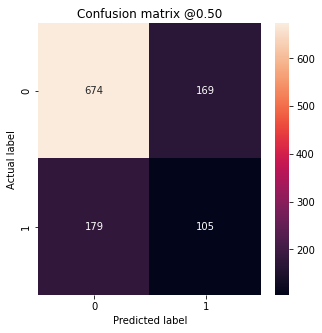

In [20]:
data['tst']['PRED'] = model.predict(dict(data['tst']))
dr = data['tst']
plot_cm(dr.TARGET, dr.PRED)

In [ ]:
dr.PRED.describe()

count    55321.000000
mean         0.358386
std          0.164123
min          0.000681
25%          0.224211
50%          0.352238
75%          0.509844
max          0.678611
Name: PRED, dtype: float64

In [ ]:
dr.PT_COTE.describe()

count    55321.000000
mean        24.407967
std         22.440965
min          5.100000
25%          9.600000
50%         17.000000
75%         29.500000
max        353.100000
Name: PT_COTE, dtype: float64

In [22]:
joue_ia = dr[dr.PRED > 0.5]
print(len(dr))
print(len(joue_ia))
print(joue_ia.TG_PLC.mean())
print(dr.TG_PLC.mean())

1127
274
0.24087591240875914
0.4072759538598048


In [26]:
calc_gains_joue(dr, 'PRED', 0.0)

GAGNANT
          joués       corrects     % corrects       gains         roi
ia         1127            179          15.88      -63.60       -5.64
hu          237             75          31.65       -1.60       -0.68
go          179            179         100.00      884.40      494.08

PLACE
          joués       corrects     % corrects       gains         roi
ia         1127            459          40.73      -31.95       -2.83
hu          237            141          59.49      -18.23       -7.69
go          459            459         100.00      636.05      138.57


In [ ]:
calc_gains_course(dr, 'PRED', 0.55)

GAGNANT
          joués       corrects     % corrects       gains         roi
ia          455             27           5.93     -117.80      -25.89
hu            1              0           0.00       -1.00     -100.00
go         1463           1463         100.00    28023.50     1915.48

PLACE
          joués       corrects     % corrects       gains         roi
ia          455            101          22.20      -66.67      -14.65
hu            1              0           0.00       -1.00     -100.00
go         5556           5556         100.00    28693.69      516.45


## Q1 - Par participation - regression sur gain attendu

In [ ]:
numerical_cols = ['CX_PRESENTS','PT_CH_AGE_OD','PT_CORDE_OD','PT_POIDS', 'PT_COTE', 'PT_CH_GAIN_PERYEAR', 'PT_CH_NBCS_WINS', 'PT_CH_NBCS_PLCS', 'PT_CH_NBCS_LOST', 'PT_CH_TX_WIN', 'PT_CH_TX_PLC','PT_CH_POIDS_IFPLC_AVG','PT_CO_TX_WIN']
cat_int_cols = [ 'PT_CH_SEXE', 'PT_CH_OEILLERE']
cat_str_cols = []
non_feature_cols = ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN','TG_PT_GAIN_W','TG_PT_GAIN_P', 'PT_COTE_OD_RAW']
features_cols = numerical_cols + cat_int_cols + cat_str_cols
sel = all[numerical_cols + non_feature_cols + cat_int_cols + cat_str_cols]

In [ ]:
df = sel[sel.PT_COTE > 0].copy()
df['TARGET'] = df.TG_PT_GAIN_P
print(df['TARGET'].describe())

count    512473.000000
mean         -0.107336
std           2.214351
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max         205.650000
Name: TARGET, dtype: float64


In [ ]:
data = utl.split_seuil(df, 'AID_CR', '17', 0.1)

trn : 402889
val : 44766
tst : 64818


In [ ]:
data['trn'] = utl.balance(data['trn'], 'TG_PLC', 0.6)

Liste des valeurs à équilibrée sur TG_PLC: 
{0: 305572, 1: 97317}
Valeur cible de l'équilibrage : 305572
Liste des valeurs après équilibrage : 
{0: 305572, 1: 222270}


In [ ]:
ds_trn, ds_val, ds_tst = to_ds(data, features_cols)
all_inputs, encoded_features,_ = create_input_layers(dataset=ds_trn)

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError()) #-12.03
#model.compile(optimizer='sgd', loss=tf.keras.losses.MeanAbsoluteError()) #??
#model.compile(optimizer='sgd', loss=tf.keras.losses.MeanAbsolutePercentageError()) #-8.3
#model.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredLogarithmicError()) #-9.74
#model.compile(optimizer='sgd', loss=tf.keras.losses.Huber()) #-8.84
#model.compile(optimizer='sgd', loss=tf.keras.losses.LogCosh()) #-9.88


In [ ]:
fit_history = model.fit(ds_trn, epochs=5, validation_data=ds_val)

Epoch 1/5
2062/2062 [==============================] - 16s 6ms/step - loss: 7.5734 - val_loss: 5.7231
Epoch 2/5
2062/2062 [==============================] - 15s 6ms/step - loss: 7.5421 - val_loss: 5.5667
Epoch 3/5
2062/2062 [==============================] - 15s 6ms/step - loss: 7.5287 - val_loss: 5.6684
Epoch 4/5
2062/2062 [==============================] - 17s 7ms/step - loss: 7.5202 - val_loss: 5.7214
Epoch 5/5
2062/2062 [==============================] - 15s 6ms/step - loss: 7.5099 - val_loss: 5.6930


In [ ]:
plot_metrics(fit_history)

In [ ]:
data['tst']['PRED'] = model.predict(dict(data['tst']))
dr = data['tst']
dr.PRED.describe()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN', 'TG_PT_GAIN_W', 'TG_PT_GAIN_P', 'PT_COTE_OD_RAW', 'TARGET'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [ ]:
calc_gains_joue(dr, 'PRED', 0.5)

GAGNANT
          joués       corrects     % corrects       gains         roi
ia        17215           3553          20.64    -2677.10      -15.55
hu         5892           1731          29.38     -983.30      -16.69
go         5726           5726         100.00    44210.30      772.10

PLACE
          joués       corrects     % corrects       gains         roi
ia        17215           8578          49.83    -1236.00       -7.18
hu         5892           3518          59.71     -602.98      -10.23
go        16401          16401         100.00    40255.99      245.45


In [ ]:
calc_gains_course(dr, 'PRED',1)

GAGNANT
          joués       corrects     % corrects       gains         roi
hu         5892           1731          29.38     -983.30      -16.69
go         5726           5726         100.00    44210.30      772.10

PLACE
          joués       corrects     % corrects       gains         roi
hu         5892           3518          59.71     -602.98      -10.23
go        16401          16401         100.00    40255.99      245.45


## Q3 TIME SERIES SUR CONDUCTEUR

In [7]:
# selectionne toute participation d'un co
# target = ecart entre attendue (PT_OD_COTE_RAW) et résultat (PT_RESULTAT)
numerical_cols = ['CX_PRESENTS','PT_CH_AGE_OD','PT_CORDE_OD','PT_POIDS', 'PT_COTE','PT_CH_GAIN_PERYEAR', 'PT_CH_NBCS_WINS', 'PT_CH_NBCS_PLCS', 'PT_CH_NBCS_LOST', 'PT_CH_TX_WIN', 'PT_CH_TX_PLC','PT_CH_POIDS_IFPLC_AVG','PT_CO_TX_WIN']
cat_int_cols = [ 'PT_CH_SEXE', 'PT_CH_OEILLERE']
cat_str_cols = []
non_feature_cols = ['AID_CR', 'AID_PT', 'TG_PLC', 'TG_WIN','TG_PT_GAIN_W','TG_PT_GAIN_P', 'PT_COTE_OD_RAW', 'TG_PT_RESULTAT', 'CO_NOM']
features_cols = numerical_cols + cat_int_cols + cat_str_cols
sel = all[numerical_cols + non_feature_cols + cat_int_cols + cat_str_cols]

In [9]:
sel_co = sel[sel.CO_NOM == 'Guyon M.'].copy()
sel_co

,CX_PRESENTS,PT_CH_AGE_OD,PT_CORDE_OD,PT_POIDS,PT_COTE,PT_CH_GAIN_PERYEAR,PT_CH_NBCS_WINS,PT_CH_NBCS_PLCS,PT_CH_NBCS_LOST,PT_CH_TX_WIN,...,AID_PT,TG_PLC,TG_WIN,TG_PT_GAIN_W,TG_PT_GAIN_P,PT_COTE_OD_RAW,TG_PT_RESULTAT,CO_NOM,PT_CH_SEXE,PT_CH_OEILLERE
121,12,1.000000,1.000000,57.5,21.652197,0.00,0,0,1,0.000000,...,080103R3C4P01,1,1,20.652197,5.163049,1.0,1.0,Guyon M.,0.0,0
247,13,1.000000,1.000000,53.0,21.652197,19000.00,0,0,1,0.000000,...,080105R1C2P15,0,0,-1.000000,-1.000000,1.0,6.0,Guyon M.,1.0,0
248,11,0.333333,1.000000,59.5,21.652197,19000.00,0,0,1,0.000000,...,080105R1C3P01,0,0,-1.000000,-1.000000,1.0,4.0,Guyon M.,0.0,0
268,10,1.000000,1.000000,53.5,21.652197,19000.00,0,0,1,0.000000,...,080105R1C4P10,0,0,-1.000000,-1.000000,1.0,6.0,Guyon M.,1.0,0
352,18,0.333333,1.000000,59.5,21.652197,19000.00,0,0,1,0.000000,...,080105R2C7P05,0,0,-1.000000,-1.000000,1.0,6.0,Guyon M.,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511775,16,1.000000,0.312500,55.5,13.400000,12358583.33,0,0,4,0.000000,...,171226R1C4P11,1,0,-1.000000,3.100000,6.0,3.0,Guyon M.,1.0,0
511783,16,1.000000,0.187500,60.5,5.200000,12366583.33,1,4,0,0.222222,...,171226R1C5P03,1,0,-1.000000,1.050000,1.0,3.0,Guyon M.,2.0,1
511800,12,1.000000,0.583333,56.5,7.200000,12384916.67,0,0,3,0.200000,...,171226R1C6P04,0,0,-1.000000,-1.000000,3.0,4.0,Guyon M.,0.0,0
511825,16,0.200000,0.937500,60.0,4.600000,12384916.67,0,2,0,0.100000,...,171226R1C8P01,0,0,-1.000000,-1.000000,1.0,6.0,Guyon M.,1.0,0


In [10]:
sel_co['TARGET'] = np.sign(sel_co.PT_COTE_OD_RAW - sel_co.TG_PT_RESULTAT)
sel_co['TARGET'] = sel_co.TARGET.mask(sel_co.TARGET == 0, -1)
sel_co['TARGET'] = sel_co.TARGET.mask(sel_co.TARGET == -1, 0)

In [11]:
sel_co[['TARGET', 'PT_COTE_OD_RAW', 'TG_PT_RESULTAT']]

,TARGET,PT_COTE_OD_RAW,TG_PT_RESULTAT
121,0.0,1.0,1.0
247,0.0,1.0,6.0
248,0.0,1.0,4.0
268,0.0,1.0,6.0
352,0.0,1.0,6.0
...,...,...,...
511775,1.0,6.0,3.0
511783,0.0,1.0,3.0
511800,0.0,3.0,4.0
511825,0.0,1.0,6.0


In [ ]:
sel_co_frame = sel_co[(sel_co.AID_CR > '16') & (sel_co.AID_CR < '1602')]
plot_cols = ['TARGET', 'PT_COTE_OD_RAW', 'TG_PT_RESULTAT']
plot_features = sel_co_frame[plot_cols]
plot_features.index = sel_co_frame.AID_CR
_ = plot_features.plot(subplots=True)


In [12]:
data = utl.split_seuil(sel_co, 'AID_CR', '17',0)
print()
print(data['trn']['TARGET'].value_counts())

trn : 8853
tst : 1127

0.0    6867
1.0    1986
Name: TARGET, dtype: int64


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
